In [3]:
%matplotlib inline

from tqdm.notebook import tqdm as tqdm

# Data Processing 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn import metrics

# Plotting 

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

# Data

import pandas as pd
import numpy as np

## Utility Tools

import itertools as it
import pickle
import random
import umap
import gc
import os

gc.collect()

174

## Loading Data

In [4]:
dataset_name = "cifar"

if dataset_name == "cifar":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\cifar"
    dataset_nonfourier_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\cifar"
    
if dataset_name == "mnist":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\mnist" 

In [9]:
with open(os.path.join(dataset_path,"datasets",dataset_name+"_labels"), 'rb') as fp:
    targets = pickle.load(fp)

with open(os.path.join(dataset_path,"datasets","weights_dictionary.pkl"), 'rb') as fp:
    weights_dict = pickle.load(fp)

targets = np.array(targets) ##new
weights_array = np.array(tuple(weights_dict.values()))

In [10]:
with open(os.path.join(dataset_nonfourier_path,"datasets",dataset_name+"_labels"), 'rb') as fp:
    targets_nonfourier = pickle.load(fp)

with open(os.path.join(dataset_nonfourier_path,"datasets","weights_dictionary.pkl"), 'rb') as fp:
    weights_dict_nonfourier = pickle.load(fp)

targets_nonfourier = np.array(targets_nonfourier) ##new
weights_array_nonfourier = np.array(tuple(weights_dict_nonfourier.values()))

## UMAP

In [ ]:
reducer = umap.UMAP(random_state=42)

In [ ]:
def plot_fig(embed,tg,digits,d_name): 

    """ Plot's UMAP clustering scatter plot

    Parameters:
    -----------
    embed : The embedding created by UMAP
    tg : The targets for each weight array or img
    digits: How amny digits are present (0-9)
    
    """

    fig = plt.figure(figsize=(10,6))
    # print(embed.shape,tg.shape)
    sc = plt.scatter(embed[:, 0], embed[:, 1], c=tg, cmap='Spectral', s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.legend(handles=sc.legend_elements()[0], labels=list(digits), prop={'size': 10})

    plt.title("UMAP projection of classes {0} - {1} of {2}".format(digits[0],digits[1],d_name), fontsize=15);
    
    
    # plt.show()
    # plt.savefig(os.path.join(dataset_path,"plots\\umaps","{digit1}_{digit2}.pdf".format(digit1 = digits[0],digit2 = digits[1]))) --> uncomment

    return sc

In [ ]:
def shuffle_arrays(arrays, set_seed=-1):
    
    """Shuffles arrays in-place, in the same order, along axis=0

    Parameters:
    -----------
    arrays : List of NumPy arrays.
    set_seed : Seed value if int >= 0, else seed is random.
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [ ]:
def plot_umaps(weights,target,digits):

    '''
        Function to return an array with only classes present in the digits variable. If the digits array has ([0,1]), then pnly instances
        where target == 0/1 are chosen and stacked together.

        return:

            wa --> new weights array
            ta --> new target array
    '''

    wa = []
    ta = []

    for i in digits:

        index = np.where(target == i)

        weights_array_temp = weights[tuple(index)]
        targets_array_temp = np.ones(weights_array_temp.shape[0])*target[index[0][0]]

        wa.append(weights_array_temp)
        ta.append(targets_array_temp)


    wa = np.vstack(wa)
    ta = np.hstack(ta)

    shuffle_arrays([wa,ta])

    return wa,ta

In [ ]:
for a,b in it.combinations(np.arange(2), 2):

    ws,ts = plot_umaps(weights_array[:,8400:8450],targets,np.array([a,b]))
    embedding = reducer.fit_transform(ws)

    plot_fig(embedding,ts,np.array([a,b]),dataset_name)

In [ ]:
# lo = 3050

# while lo <9051:

layers = [0,6400,6450,8950,9000,9050,9051]
images_layers = []
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,20))

for lo in range(len(layers)-3):
    
    for a,b in it.combinations(np.arange(2), 2):
        
        print("Plot for {0}-{1}".format(layers[lo],layers[lo+1]))
        ws,ts = plot_umaps(weights_array[:,layers[lo]:layers[lo+1]],targets,np.array([a,b]))
        embedding = reducer.fit_transform(ws)

        plt.scatter(embedding[:, 0], embedding[:, 1], c=ts, cmap='Spectral', s=10)

    # lo += 50

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
for idx, image in enumerate(images_layers):
    row = idx // 2
    col = idx % 3
    axes[row, col].axis("off")
    axes[row, col].imshow(image, cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
# fig.add_collection(images_layers)
# # for ax, im in zip(grid,random.sample( range(0, 10000), 4)):
for ax, im in zip(grid,np.arange(len(images_layers))):
    # Iterating over the grid returns the Axes.
    
    ax.imshow(images_layers[im])
    # fig.savefig(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\plots\Observations\cifar_weights_plotted.pdf")
    plt.title("Weights array plotted for image no {image_no}".format(image_no=im))
plt.show()

## Classifier

In [13]:
# def classifier(input_array,labels,c_name,scale,pca_val = None):

#     input_data = input_array
    
#     if scale == True:
        
#         scaler = StandardScaler()
#         input_data = scaler.fit_transform(input_data)

#     if pca_val != None:

#         pca = PCA(n_components=pca_val)
#         input_data = pca.fit_transform(input_data)
        

#     x_train, x_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.25, random_state=42)

#     if c_name == "logit":

#         logisticRegr = LogisticRegression(solver = 'lbfgs')
#         logisticRegr.fit(x_train, y_train)

#         y_pred = logisticRegr.predict(x_test)

#         # Use score method to get accuracy of model
#         test_accuracy = logisticRegr.score(x_test, y_test)
#         train_accuracy = logisticRegr.score(x_train,y_train)
        
#     if c_name == "forest":
        
#         rf = RandomForestClassifier(n_estimators=300,max_depth=14,oob_score = True)
#         rf.fit(x_train, y_train)    

#         y_pred = rf.predict(x_test)

#         test_accuracy = accuracy_score(y_test, y_pred)
#         train_accuracy = rf.oob_score_
    
#     # Metrics

#     # print("Test accuracy",test_accuracy,"Train accuracy",train_accuracy)
    
#     cm = metrics.confusion_matrix(y_test, y_pred) # Confusion matrix

#     plt.figure(figsize=(9,9))
#     sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
#     plt.ylabel('Actual label');
#     plt.xlabel('Predicted label');
#     all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy)
#     plt.title(all_sample_title, size = 15);
#     # # plt.savefig("C:/Users/ayush/OneDrive/Desktop/UoE/Dissertation/Implicit Networks/plots/metrics/{classifier}_{pca}.pdf".format(classifier = c_name,pca = pca_val))
#     # plt.savefig(os.path.join(dataset_path,"plots\\metrics","CIFAR_Weights_{classifier}_{pca}.pdf".format(classifier = c_name,pca = pca_val)))
        
#     return test_accuracy,train_accuracy

In [15]:
def classifier(input_array,tg,c_name,d_name,scale,pca_val = None):

    input_data = input_array
    
    if scale == True:
        
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)

    if pca_val != None:

        pca = PCA(n_components=pca_val)
        input_data = pca.fit_transform(input_data)
        

    x_train, x_test, y_train, y_test = train_test_split(input_data, tg, test_size=0.25, random_state=42)

    if c_name == "logit":

        logisticRegr = LogisticRegression(solver = 'sag',penalty = 'l2')
        logisticRegr.fit(x_train, y_train)

        y_pred = logisticRegr.predict(x_test)

        # Use score method to get accuracy of model
        test_accuracy = logisticRegr.score(x_test, y_test)
        train_accuracy = logisticRegr.score(x_train,y_train)
        
    if c_name == "forest":
        
        rf = RandomForestClassifier(n_estimators=300,max_depth=14,oob_score = True)
        rf.fit(x_train, y_train)    

        y_pred = rf.predict(x_test)

        test_accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = rf.oob_score_
    
    # Metrics

    # print("Test accuracy",test_accuracy,"Train accuracy",train_accuracy)
    print(train_accuracy,test_accuracy)       
    cm = metrics.confusion_matrix(y_test, y_pred) # Confusion matrix

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,cbar=False, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Test Accuracy: {0} / Train Accuracy: {1}'.format(test_accuracy,train_accuracy)
    note = 'Confusion matric for {0} with PCA (={1}) on {2} dataset'.format(c_name,pca_val,d_name)
    plt.figtext(0.5, 0.01,note, ha="center", fontsize=15,color ="black") #bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.title(all_sample_title, size = 15);
    
    # plt.savefig(os.path.join(dataset_path,"plots\\metrics",note+".pdf"))
    plt.show()
    return 0

### Visualise

In [27]:
classifier(weights_array,targets,'forest',True,200)

(0.1924, 0.17613333333333334)

In [ ]:
classifier(weights_array,targets,'forest',True,300)


 ------- Reconstructed Image ----------------
0.16893333333333332 0.1904


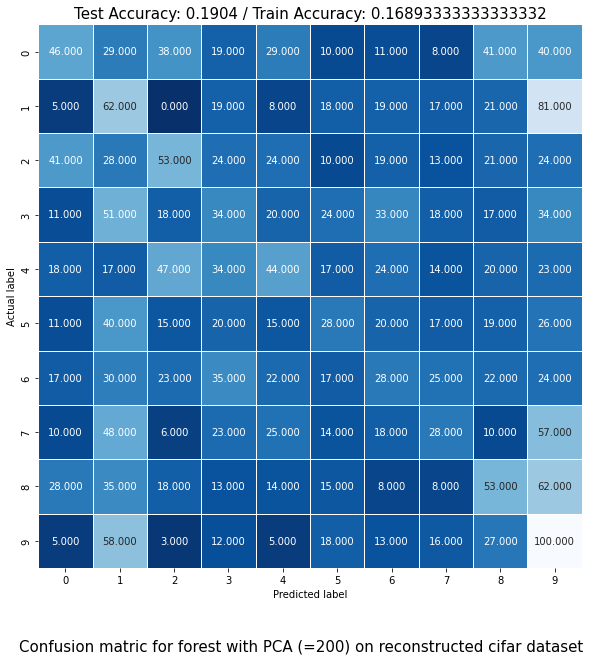


 ------- Reconstructed Non-fourier Image ----------------
0.14733333333333334 0.1712


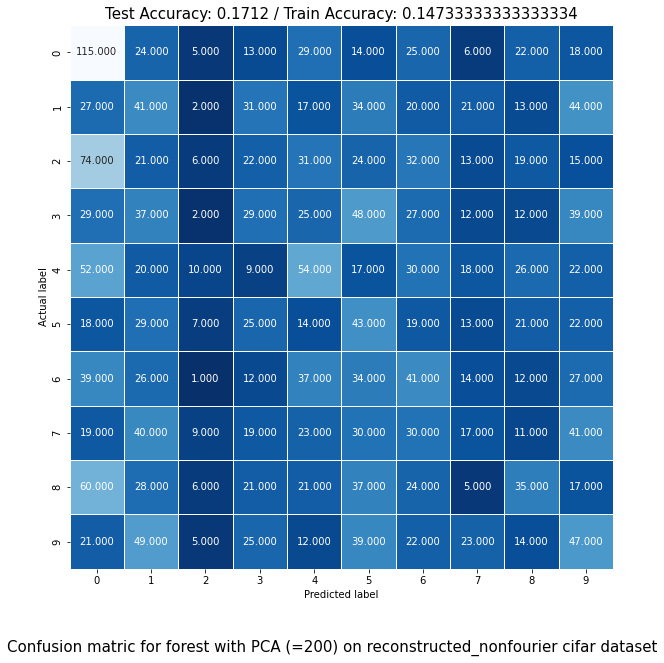

0

In [17]:
pca_features = 200

print("\n", "------- Reconstructed Image ----------------")
classifier(weights_array,targets,'forest',"reconstructed "+dataset_name,True,pca_features)
print("\n", "------- Reconstructed Non-fourier Image ----------------")
classifier(weights_array_nonfourier,targets_nonfourier,'forest',"reconstructed_nonfourier "+dataset_name,True,pca_features)

## Exploring Weights


In [ ]:
index = np.where(targets == 0)[0][:4].tolist()
index.extend(np.where(targets == 3)[0][:4].tolist())

In [ ]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

# for ax, im in zip(grid,random.sample( range(0, 10000), 4)):
for ax, im in zip(grid,index):
    # Iterating over the grid returns the Axes.
    
    ax.imshow(weights_dict[str(im)][:9025].reshape(95,95),cmap = 'gray')
    # fig.savefig(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\plots\Observations\cifar_weights_plotted.pdf")
    plt.title("Weights array plotted for image no {image_no}".format(image_no=im))
plt.show()

In [ ]:
for x in np.where(targets==4)[0][1:]:

    print(np.linalg.norm(weights_dict['4'] - weights_dict[str((x))]))

In [ ]:
layers = [0,6400,6450,8950,9000,9050,9051]
l_names = ["Null","Layer 1","Bias 1","Layer 2","Bias 2","Layer 3","Output"]


for i in range(1,len(layers)):
    print(l_names[i],"-->",layers[i]-layers[i-1],"-->",np.abs(weights_array[layers[i-1]:layers[i]]).sum())
    print(np.abs(weights_array[i-1:i]))
    print("\n---- END ------")
    # weights_array[layers[i-1]:layers[i]].sum()

In [ ]:
dataset = pd.DataFrame(weights_array[0]).abs().nlargest(100,0)
temp = pd.DataFrame(np.int64(np.floor(dataset.index.values / 50) * 50))

In [ ]:
def pixel_counts(weights):

    dataset = pd.DataFrame(weights).abs().nlargest(100,0)
    temp = pd.DataFrame(np.int64(np.floor(dataset.index.values / 50) * 50)) ## change (number to x) to round to closest x muliplte

    return temp.apply(pd.value_counts)

In [ ]:
list_pd = []

for i in range(10000):
    
    list_pd.append(pixel_counts(weights_array[i]))

df = pd.concat(list_pd, axis=1)

df.sum(axis=1)

## 100 instance - 2 class experiment

In [42]:
indices = np.where((targets == 2 )|(targets == 6))[0]

In [49]:
class_weights = weights_array[indices]
class_targets = targets[indices]
# class_6_weights = weights_array[np.where(targets==6)][:100]

(0.5857142857142857, 0.702316076294278)

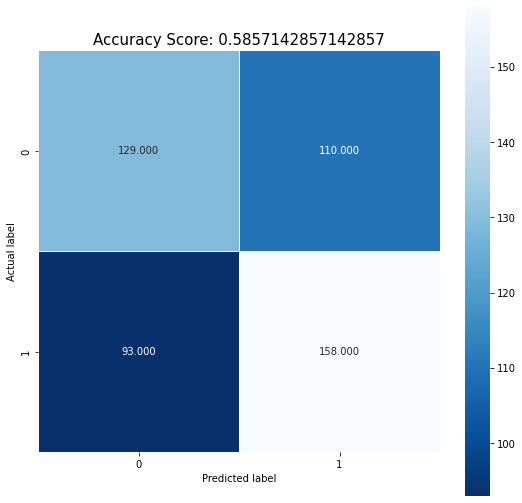

In [56]:
classifier(class_weights,class_targets,'logit',True,200)

(0.6224489795918368, 0.614441416893733)

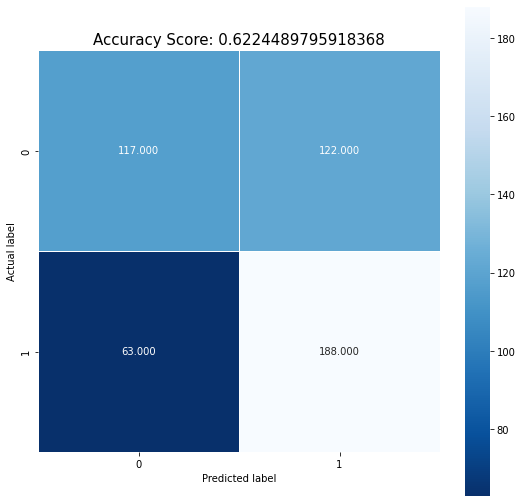

In [58]:
classifier(class_weights,class_targets,'forest',True,200)

## Archive

### SVM with RBF

In [ ]:
# from sklearn.svm import SVC, LinearSVC
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score

In [ ]:
# coefficient = []
# n_supp = []
# sup_vec = []
# i = 0
# df = pd.DataFrame(columns = ['c','gamma','train_acc','test_acc'])
# for c in [10]:
#     for g in [0.01]:
#         svm = SVC(kernel='rbf', C=c, gamma=g)
#         model = svm.fit(x_train, y_train)
#         globals()['model%s' % i] = model
#         d_coef = svm.dual_coef_
#         support = svm.n_support_
#         sv = svm.support_
    
#         p_tr = svm.predict(x_train)
#         a_tr = accuracy_score(y_train, p_tr)
    
#         pred = svm.predict(x_test)
#         a = accuracy_score(y_test, pred)
    
#         coefficient.append(d_coef)
#         n_supp.append(support)
#         sup_vec.append(sv)
#         df.loc[i] = [c,g,a_tr,a]
#         i=i+1



### UMAP Plot

In [ ]:
# list1 = np.array([0,5])

# wa = []
# ta = []

# for i in list1:

#     index = np.where(targets == i)

#     weights_array_temp = weights_array[tuple(index)]
#     targets_array_temp = np.ones(weights_array_temp.shape[0])*targets[index[0][0]]

#     wa.append(weights_array_temp)
#     ta.append(targets_array_temp)


# wa = np.vstack(wa)
# ta = np.hstack(ta)

# shuffle_arrays([wa,ta])

# embedding = reducer.fit_transform(np.delete(wa,np.s_[9050:-1],1))

# plot_fig(embedding,ta,list1,5)

In [ ]:
# weights_pd = pd.DataFrame.from_dict(weights)
# weights_pd['digit'] = pd.Series(targets).map(lambda x: 'Digit {}'.format(x))

In [ ]:
# def plot_embedding(interval=19):

#     for i in range(interval):

#         embedding = reducer.fit_transform(np.delete(weights_array,np.s_[500+i:-1],1))

#         plot_fig(embedding,targets,500+i)

#     embedding = reducer.fit_transform(np.delete(weights_array,np.s_[9049+i:-1],1))
#     plot_fig(embedding,targets,9049)


In [ ]:
# with open("../data/labels", 'rb') as fp:
#     targets = pickle.load(fp)

# with open('../data/weights_dictionary.pkl', 'rb') as fp:
#     weights = pickle.load(fp)

# targets = np.array(targets) ##new